In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sqlalchemy import create_engine

In [2]:
PG_HOST = '172.17.0.2'
pg_engine = create_engine(f'postgresql+psycopg2://postgres:password@{PG_HOST}/habr', pool_recycle=3600)
pg_conn = pg_engine.connect()

In [3]:
import pandas as pd

posts_df = pd.read_sql("select * from posts", pg_conn)
print("Posts count: ", len(posts_df))
posts_df.head(2)

Posts count:  232127


,post_id,title,text,date,views_count,comments_count,bookmarks_count,rating,author_nickname
0,365293,LinkedIn автоматизировал добавление в профиль ...,Разработчики LinkedIn объявили о появившейся в...,2015-03-26 16:32:00,7300,1,10,+8,Teachbase
1,5005,MobileFaker: фальшивые звонки как социальное о...,Со своего мобильника вы заказываете фальшивый ...,2007-01-26 14:39:00,315,17,2,+16,alizar


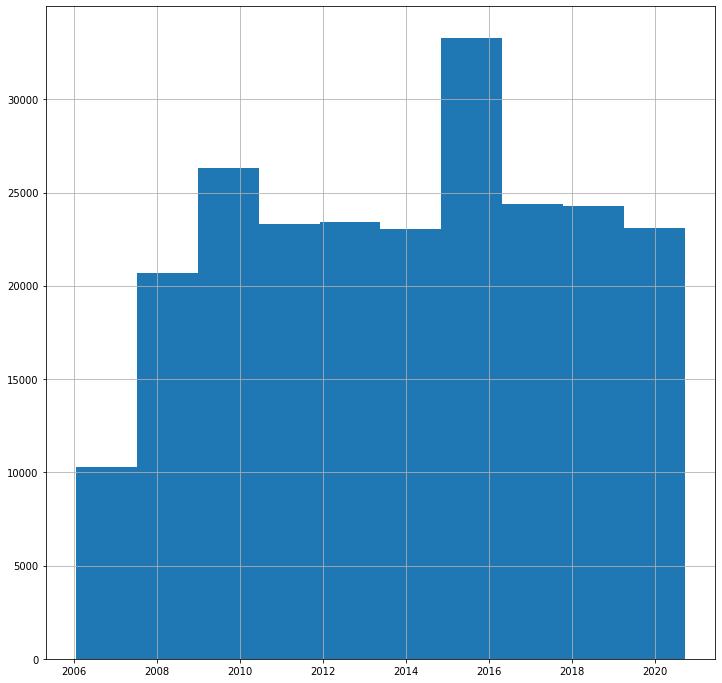

In [114]:
plt.figure(figsize=(12, 12))
posts_df['date'].hist()
plt.show()

In [4]:
tags_df = pd.read_sql("select * from tags", pg_conn)
print("tags_df len: ", len(tags_df))
tags_df.head(2)

tags_df len:  1054820


,post_id,tag
0,365293,LinkedIn
1,365293,онлайн-курсы


In [5]:
habs_df = pd.read_sql("select * from habs", pg_conn)
print("tags_df len: ", len(habs_df))
habs_df.head(2)

tags_df len:  447893


,post_id,hab
0,365293,Блог компании Teachbase.ru
1,365293,Социальные сети и сообщества


In [6]:
habs_df['hab'].value_counts()

Чулан                                               29221
Разработка веб-сайтов                               12309
Программирование                                    11680
Информационная безопасность                         11232
IT-компании                                          8710
                                                    ...  
Блог компании Агентство Стратегических Инициатив        1
Блог компании Geometria                                 1
Блог компании Taptostart                                1
Блог компании BugHunt                                   1
Блог компании Track Task                                1
Name: hab, Length: 2269, dtype: int64

In [7]:
tags_df['tag'].value_counts()

javascript       4473
android          4011
google           3726
linux            3274
php              3224
                 ... 
method size         1
боны                1
applicatives        1
Дугин               1
stereo player       1
Name: tag, Length: 204532, dtype: int64

In [8]:
def get_habs_list(post_id: int) -> str:
    habs = ''
    for _, row in habs_df[habs_df['post_id'] == post_id].iterrows():
        habs += (row['hab'] + '<SEP>')
    return habs[:-5]

get_habs_list(5005)

'Чулан'

In [9]:
def get_tags_list(post_id: int) -> str:
    tags = ''
    for _, row in tags_df[tags_df['post_id'] == post_id].iterrows():
        tags += (row['tag'] + '<SEP>')
    return tags[:-5]

get_tags_list(5005)

'MobileFaker<SEP>фальшивые звонки<SEP>лицемерие<SEP>мобильные услуги<SEP>соци'

In [10]:
posts_df['habs'] = posts_df.apply(lambda x: get_habs_list(x['post_id']), axis=1)
posts_df['tags'] = posts_df.apply(lambda x: get_tags_list(x['post_id']), axis=1)
posts_df.head(2)

,post_id,title,text,date,views_count,comments_count,bookmarks_count,rating,author_nickname,habs,tags
0,365293,LinkedIn автоматизировал добавление в профиль ...,Разработчики LinkedIn объявили о появившейся в...,2015-03-26 16:32:00,7300,1,10,+8,Teachbase,Блог компании Teachbase.ru<SEP>Социальные сети...,LinkedIn<SEP>онлайн-курсы<SEP>сертификаты<SEP>...
1,5005,MobileFaker: фальшивые звонки как социальное о...,Со своего мобильника вы заказываете фальшивый ...,2007-01-26 14:39:00,315,17,2,+16,alizar,Чулан,MobileFaker<SEP>фальшивые звонки<SEP>лицемерие...


In [11]:
habs_dict = dict(habs_df['hab'].value_counts())
habs_list = list(habs_dict.keys())
len(habs_dict), list(habs_dict.items())[:1]

(2269, [('Чулан', 29221)])

In [12]:
tags_dict = dict(tags_df['tag'].value_counts())
tags_list = list(tags_dict.keys())
len(tags_dict), list(tags_dict.items())[:1]

(204532, [('javascript', 4473)])

In [13]:
class Habs2Vec:
    
    habs2code: dict
    code2hab: dict
    
    def fit(self, habs_list: list) -> None:
        self.habs2code = {hab: i for i, hab in enumerate(habs_list)}
        self.code2hab = {i: hab for i, hab in enumerate(habs_list)}
        
    def transform(self, post_habs: list) -> np.array:
        vec = np.zeros(len(self.habs2code), dtype=np.int0)
        for hab in post_habs:
            vec[self.habs2code[hab]] = 1
        return vec
    
    def encode_vec(self, vec: np.array) -> list:
        habs = []
        for i, elem in enumerate(vec):
            if elem:
                habs.append(self.code2hab[i])
        return habs
    
transformer = Habs2Vec()
transformer.fit(habs_list)
print('Habs: ', habs_list[:2] + habs_list[-2:])
vec = transformer.transform(habs_list[:2] + habs_list[-2:])
print('Binary vector: ', vec)
print('Decoded binary vector: ', transformer.encode_vec(vec))

Habs:  ['Чулан', 'Разработка веб-сайтов', 'Блог компании BugHunt', 'Блог компании Track Task']
Binary vector:  [1 1 0 ... 0 1 1]
Decoded binary vector:  ['Чулан', 'Разработка веб-сайтов', 'Блог компании BugHunt', 'Блог компании Track Task']


In [14]:
decoded_habs_list = [transformer.transform(post['habs'].split('<SEP>')) for _, post in tqdm.tqdm(posts_df.iterrows())]
len(decoded_habs_list), decoded_habs_list[:2]

232127it [00:18, 12670.35it/s]


(232127, [array([0, 0, 0, ..., 0, 0, 0]), array([1, 0, 0, ..., 0, 0, 0])])

In [17]:
import json

with open('decoded_habs_list.json', 'w') as f:
    for vec in tqdm.tqdm(decoded_habs_list):
        f.write(json.dumps(list([int(v) for v in vec])))
        f.write('\n')

100%|██████████| 232127/232127 [01:56<00:00, 1989.26it/s]


In [19]:
authors_list = list({post['author_nickname'] for _, post in posts_df.iterrows()})
len(authors_list)

38349

In [29]:
habs_stat = {
    hab: {
        'comments_count': 0,
        'rating': 0,
        'bookmarks_count': 0,
        'views_count': 0,
        'authors_set': set(),
        'count': 0
    } for hab in habs_list}
tags_stat = {
    tag: {
        'comments_count': 0,
        'rating': 0,
        'bookmarks_count': 0,
        'views_count': 0,
        'authors_set': set(),
        'count': 0
    } for tag in tags_list}
authors_stat = {
    author: {
        'comments_count': 0,
        'rating': 0,
        'bookmarks_count': 0,
        'views_count': 0,
        'habs_set': set(),
        'tags_set': set(),
        'count': 0
    } for author in authors_list}

def parse_rating(rating: str) -> int:
    if rating[0] == '–':
        return -int(rating[1:])
    return int(rating)

for _, post in tqdm.tqdm(posts_df.iterrows()):
    post_id = post['post_id']
    author = post['author_nickname']
    comments_count = post['comments_count']
    views_count = post['views_count']
    bookmarks_count = post['bookmarks_count']
    authors_stat[author]['count'] += 1
    rating = parse_rating(str(post['rating']).strip())
    habs = str(post['habs']).split('<SEP>')
    tags = str(post['tags']).split('<SEP>')
    
    authors_stat[author]['comments_count'] += comments_count
    authors_stat[author]['views_count'] += views_count
    authors_stat[author]['bookmarks_count'] += bookmarks_count
    authors_stat[author]['count'] += 1
    authors_stat[author]['rating'] += rating
    authors_stat[author]['habs_set'] |= set(habs)
    authors_stat[author]['tags_set'] |= set(tags)
    
    for hab in habs:
        habs_stat[hab]['comments_count'] += comments_count
        habs_stat[hab]['bookmarks_count'] += bookmarks_count
        habs_stat[hab]['views_count'] += views_count
        habs_stat[hab]['authors_set'].add(author)
        habs_stat[hab]['rating'] += rating
        habs_stat[hab]['count'] += 1  
        
    for tag in tags:
        tags_stat[tag]['comments_count'] += comments_count
        tags_stat[tag]['bookmarks_count'] += bookmarks_count
        tags_stat[tag]['views_count'] += views_count
        tags_stat[tag]['authors_set'].add(author)
        tags_stat[tag]['rating'] += rating
        tags_stat[tag]['count'] += 1    

print('Habs stat item:', list(habs_stat.items())[:1])
print('Tags stat item:', list(tags_stat.items())[:1])
print('Authors stat item:', list(authors_stat.items())[:1])

232127it [00:35, 6480.89it/s]

Habs stat item: [('Чулан', {'comments_count': 605766, 'rating': 205596, 'bookmarks_count': 137265, 'views_count': 20280127, 'authors_set': {'freiman', 'RUQ', 'Antares19', 'ALIron', 'platinum07', 'mmx', 'yamalight', 'Akram', 'intenter', 'unclegluk', 'kpblca', 'MTonly', 'Ruster', 'Glow', 'vvovas', 'cadovvl', 'LaCroix', 'Jahar', 'webRunes', 'Imbolc', 'animalism2', 'silvergh0st', 'Lipa', 'Apostol', 'Tronum', 'Reznikov', 'metalink', 'readysteady', 'heoh', 'M4rkK1d', 'biblos', 'dust', 'toxa', 'vityasev', 'Commandante', 'lordik', 'aleksey_druzhinin', 'DmitryKoterov', 'britoff', 'stardust_kid', 'penexe', 'denisf', 'gulevich', 'vo0d', 'Hellcat', 'Tims', 'unu', 'alevtino4ka', '21csm', 'meettya', 'vorobyev', 'NjabuloJahra', 'lvea', 'Shweda', 'alex_bio', 'FuPro', 'MrJeka', 'Ecugool', 'overday', 'hrebet', 'Grushevskiy', 'denisnikulin', 'Chronicler', 'umonkey', 'xbons', 'bliznezz', 'GambiTst', 'dimazub', 'oshoss', 'Semenov', 'Alex--T', 'adeator', 'steff', 'har1ton', 'alexanderST', 'cherry', 'dinozav

In [103]:
habs_stat_df = pd.DataFrame({
    'hab': list(habs_stat),
    'views_count': [habs_stat[hab]['views_count'] // habs_stat[hab]['count'] for hab in habs_stat],
    'comments_count': [habs_stat[hab]['comments_count'] // habs_stat[hab]['count'] for hab in habs_stat],
    'bookmarks_count': [habs_stat[hab]['bookmarks_count'] // habs_stat[hab]['count'] for hab in habs_stat],
    'rating': [habs_stat[hab]['rating'] // habs_stat[hab]['count'] for hab in habs_stat],
    'count': [habs_stat[hab]['count'] for hab in habs_stat]
})
habs_stat_df.head(10)

,hab,views_count,comments_count,bookmarks_count,rating,count
0,Чулан,694,20,4,7,29221
1,Разработка веб-сайтов,26569,32,138,27,12309
2,Программирование,24840,33,114,26,11680
3,Информационная безопасность,25108,41,72,31,11232
4,IT-компании,10664,49,17,24,8710
5,Научно-популярное,19957,59,41,28,7804
6,JavaScript,23922,26,131,24,6585
7,Гаджеты,18933,45,31,20,6508
8,Я пиарюсь,3596,41,35,24,5564
9,Компьютерное железо,20403,52,38,26,4840


In [102]:
tags_stat_df = pd.DataFrame({
    'tag': list(tags_stat),
    'views_count': [tags_stat[tag]['views_count'] // tags_stat[tag]['count'] for tag in tags_stat],
    'comments_count': [tags_stat[tag]['comments_count'] // tags_stat[tag]['count'] for tag in tags_stat],
    'bookmarks_count': [tags_stat[tag]['bookmarks_count'] // tags_stat[tag]['count'] for tag in tags_stat],
    'rating': [tags_stat[tag]['rating'] // tags_stat[tag]['count'] for tag in tags_stat],
    'count': [tags_stat[tag]['count'] for tag in tags_stat]
})
tags_stat_df.head(10)

,tag,views_count,comments_count,bookmarks_count,rating,count
0,javascript,21386,30,118,25,4473
1,android,22546,31,70,23,4011
2,google,10986,39,29,24,3726
3,linux,25097,43,99,30,3274
4,php,19032,39,94,21,3224
5,python,24047,24,117,26,3022
6,java,25873,23,93,20,3004
7,программирование,25108,40,106,26,2923
8,разработка,20781,27,107,25,2862
9,microsoft,10352,40,23,20,2749


In [101]:
authors_stat_df = pd.DataFrame({
    'author': list(authors_stat),
    'views_count': [authors_stat[author]['views_count'] // authors_stat[author]['count'] for author in authors_stat],
    'comments_count': [authors_stat[author]['comments_count'] // authors_stat[author]['count'] for author in authors_stat],
    'bookmarks_count': [authors_stat[author]['bookmarks_count'] // authors_stat[author]['count'] for author in authors_stat],
    'rating': [authors_stat[author]['rating'] // authors_stat[author]['count'] for author in authors_stat],
    'count': [authors_stat[author]['count'] for author in authors_stat]
})
authors_stat_df.head(10)

,author,views_count,comments_count,bookmarks_count,rating,count
0,freiman,8163,19,12,6,20
1,RUQ,1480,18,15,10,74
2,shmidt-m,6621,21,13,1,14
3,Altf1,172,2,1,0,2
4,bvrmn,2550,32,21,7,2
5,wizp,8050,2,35,1,2
6,shane54,178,0,0,0,2
7,ArkadyBagdasarov,1650,2,12,7,2
8,Akram,80,8,1,5,2
9,ViktoriaTok,5900,3,11,12,2


In [158]:
import matplotlib.pyplot as plt

count_threshold = 500
figsize = (10, 10)

# Statistics plots

## Most viewed

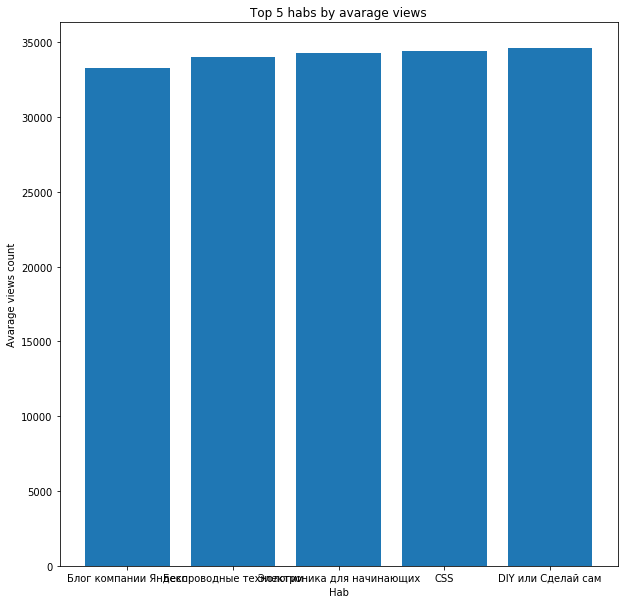

In [159]:
plt.figure(figsize=figsize)
top_views_habs = habs_stat_df[habs_stat_df['count'] > count_threshold].sort_values('views_count').tail(5)
plt.title('Top 5 habs by avarage views')
plt.bar(top_views_habs['hab'].values, top_views_habs['views_count'].values)
plt.xlabel('Hab')
plt.ylabel('Avarage views count')
plt.show()

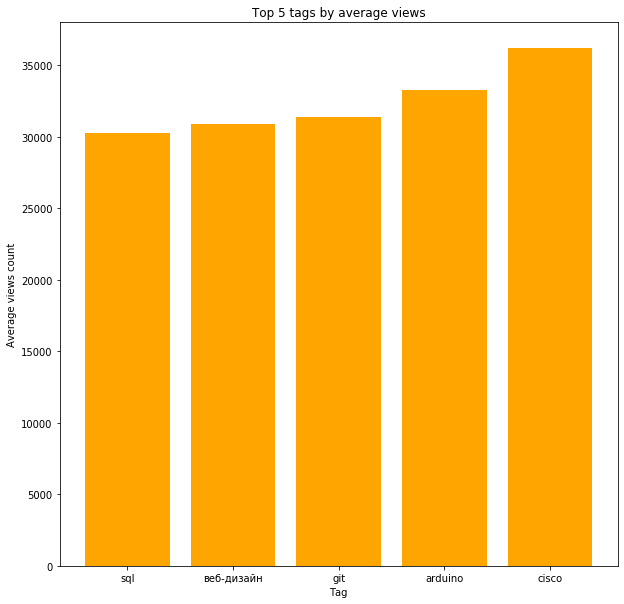

In [160]:
plt.figure(figsize=figsize)
top_views_tags = tags_stat_df[tags_stat_df['count'] > count_threshold].sort_values('views_count').tail(5)
plt.title('Top 5 tags by average views')
plt.bar(top_views_tags['tag'].values, top_views_tags['views_count'].values, color='orange')
plt.xlabel('Tag')
plt.ylabel('Average views count')
plt.show()

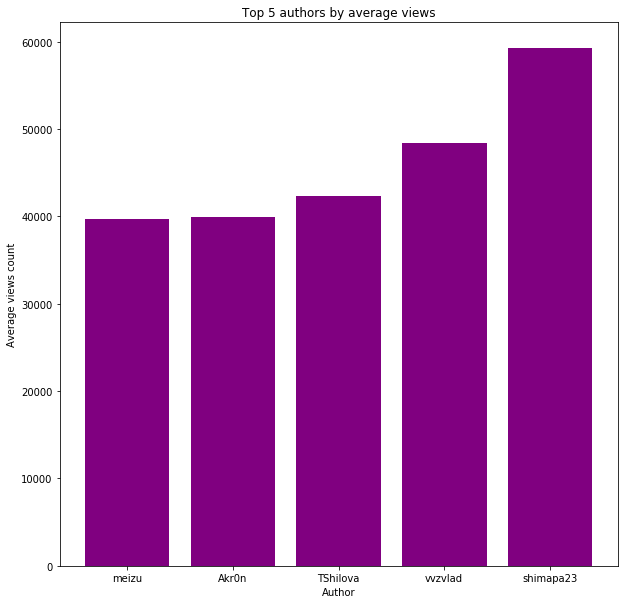

In [161]:
plt.figure(figsize=figsize)
top_authors_tags = authors_stat_df[authors_stat_df['count'] > count_threshold // 10].sort_values('views_count').tail(5)
plt.title('Top 5 authors by average views')
plt.bar(top_authors_tags['author'].values, top_authors_tags['views_count'].values, color='purple')
plt.xlabel('Author')
plt.ylabel('Average views count')
plt.show()

## Most rated

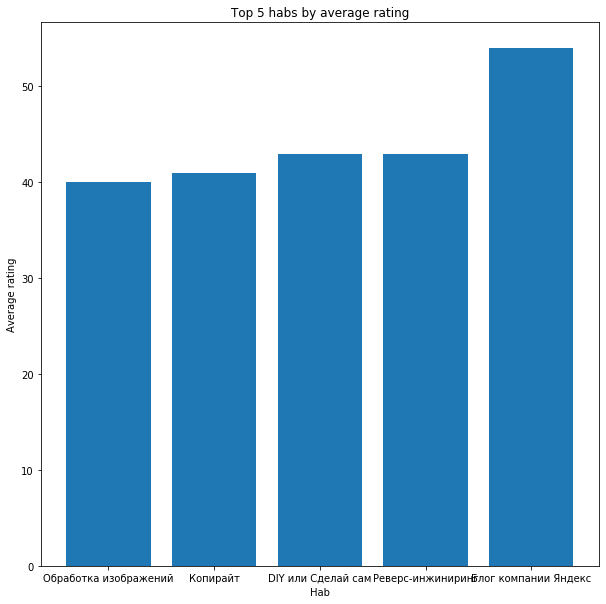

In [162]:
plt.figure(figsize=figsize)
top_rating_habs = habs_stat_df[habs_stat_df['count'] > count_threshold].sort_values('rating').tail(5)
plt.title('Top 5 habs by average rating')
plt.bar(top_rating_habs['hab'].values, top_rating_habs['rating'].values)
plt.xlabel('Hab')
plt.ylabel('Average rating')
plt.show()

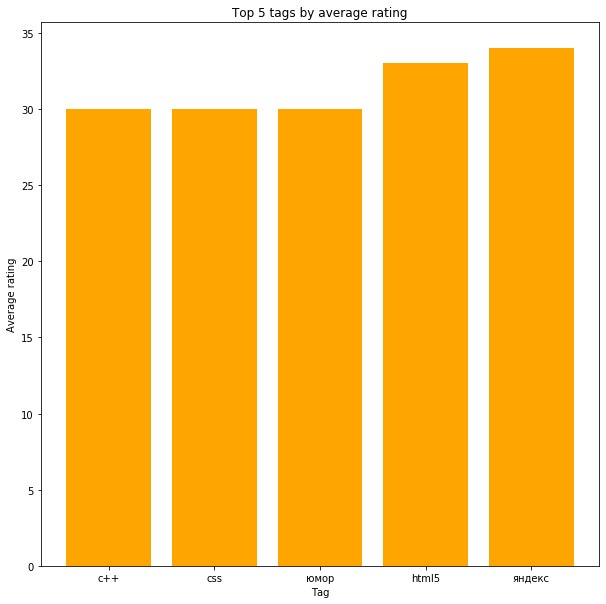

In [163]:
plt.figure(figsize=figsize)
top_rating_tags = tags_stat_df[tags_stat_df['count'] > 1000].sort_values('rating').tail(5)
plt.title('Top 5 tags by average rating')
plt.bar(top_rating_tags['tag'].values, top_rating_tags['rating'].values, color='orange')
plt.xlabel('Tag')
plt.ylabel('Average rating')
plt.show()

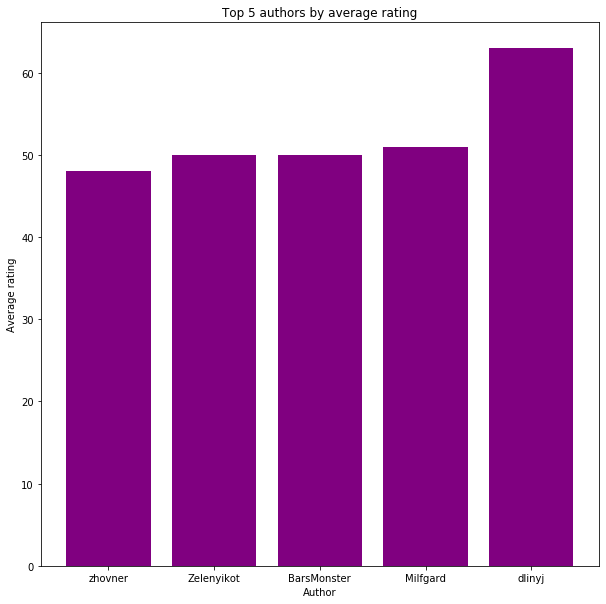

In [164]:
plt.figure(figsize=figsize)
top_rating_authors = authors_stat_df[authors_stat_df['count'] > count_threshold // 10].sort_values('rating').tail(5)
plt.title('Top 5 authors by average rating')
plt.bar(top_rating_authors['author'].values, top_rating_authors['rating'].values, color='purple')
plt.xlabel('Author')
plt.ylabel('Average rating')
plt.show()

## Most bookmarked

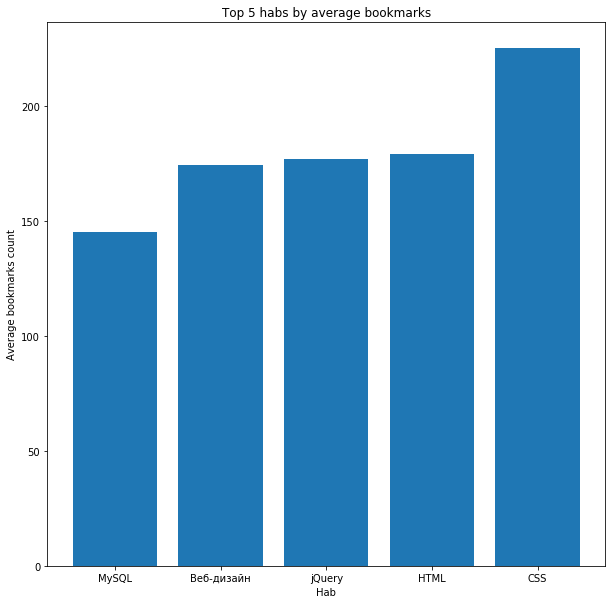

In [165]:
plt.figure(figsize=figsize)
top_bookmarks_habs = habs_stat_df[habs_stat_df['count'] > count_threshold].sort_values('bookmarks_count').tail(5)
plt.title('Top 5 habs by average bookmarks')
plt.bar(top_bookmarks_habs['hab'].values, top_bookmarks_habs['bookmarks_count'].values)
plt.xlabel('Hab')
plt.ylabel('Average bookmarks count')
plt.show()

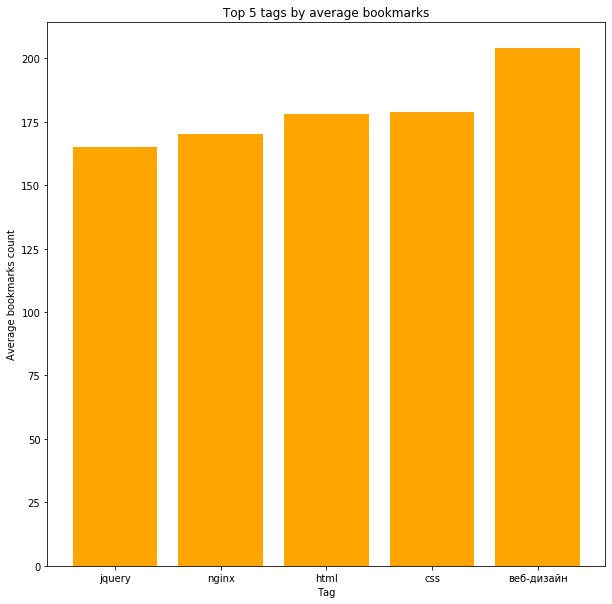

In [166]:
plt.figure(figsize=figsize)
top_bookmarks_tags = tags_stat_df[tags_stat_df['count'] > count_threshold].sort_values('bookmarks_count').tail(5)
plt.title('Top 5 tags by average bookmarks')
plt.bar(top_bookmarks_tags['tag'].values, top_bookmarks_tags['bookmarks_count'].values, color='orange')
plt.xlabel('Tag')
plt.ylabel('Average bookmarks count')
plt.show()

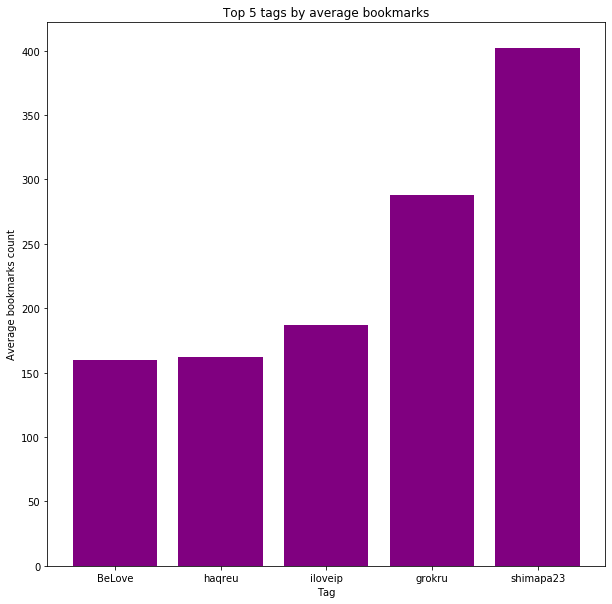

In [167]:
plt.figure(figsize=figsize)
top_bookmarks_authors = authors_stat_df[authors_stat_df['count'] > count_threshold // 10].sort_values('bookmarks_count').tail(5)
plt.title('Top 5 tags by average bookmarks')
plt.bar(top_bookmarks_authors['author'].values, top_bookmarks_authors['bookmarks_count'].values, color='purple')
plt.xlabel('Tag')
plt.ylabel('Average bookmarks count')
plt.show()

## Most commented

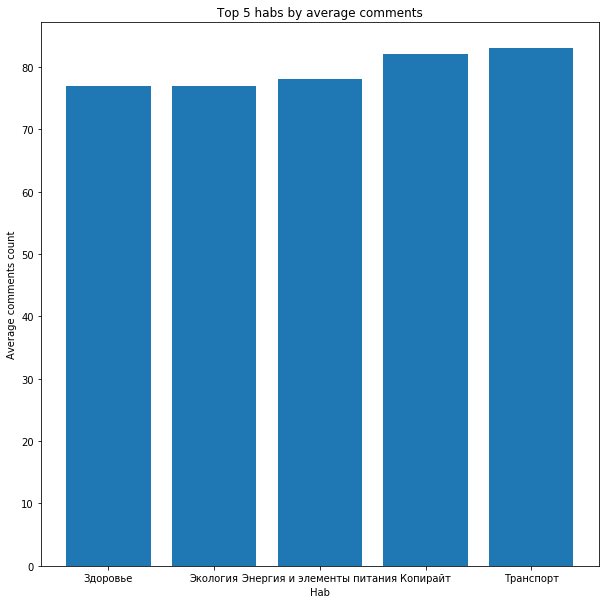

In [168]:
plt.figure(figsize=figsize)
top_comments_habs = habs_stat_df[habs_stat_df['count'] > count_threshold].sort_values('comments_count').tail(5)
plt.title('Top 5 habs by average comments')
plt.bar(top_comments_habs['hab'].values, top_comments_habs['comments_count'].values)
plt.xlabel('Hab')
plt.ylabel('Average comments count')
plt.show()

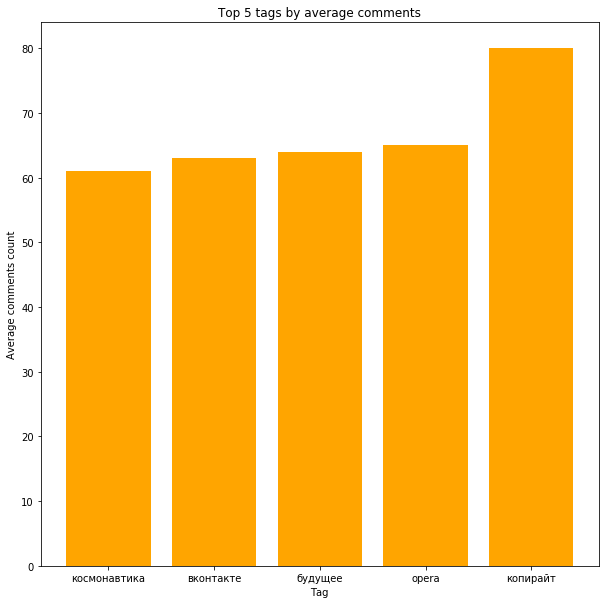

In [169]:
plt.figure(figsize=figsize)
top_comments_tags = tags_stat_df[tags_stat_df['count'] > count_threshold].sort_values('comments_count').tail(5)
plt.title('Top 5 tags by average comments')
plt.bar(top_comments_tags['tag'].values, top_comments_tags['comments_count'].values, color='orange')
plt.xlabel('Tag')
plt.ylabel('Average comments count')
plt.show()

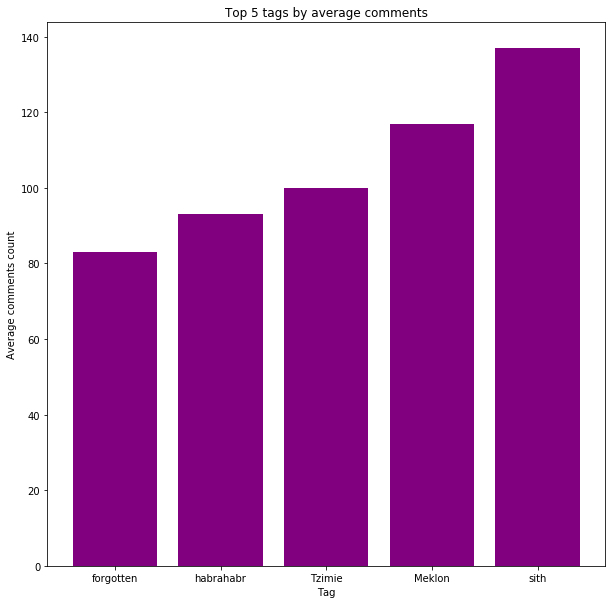

In [170]:
plt.figure(figsize=figsize)
top_comments_authors = authors_stat_df[authors_stat_df['count'] > count_threshold // 10].sort_values('comments_count').tail(5)
plt.title('Top 5 tags by average comments')
plt.bar(top_comments_authors['author'].values, top_comments_authors['comments_count'].values, color='purple')
plt.xlabel('Tag')
plt.ylabel('Average comments count')
plt.show()